# Modelado de topicos

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install -q spacy
!python -m spacy download en_core_web_sm

import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 8.5 MB/s eta 0:00:00m eta 0:00:010:00:01m
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
df = pd.read_csv('scripts/captions_dataset.csv', quotechar='"')
df.head()

,id,video_name,fps,label,caption_pedestrian,caption_vehicle,start_time,end_time
0,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,prerecognition,"The pedestrian, a woman in her 50s, stood diag...","The vehicle, traveling at a constant speed of ...",35.073,35.106
1,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,recognition,"The pedestrian, a female in her 50s, stood dia...",The vehicle was moving at a constant speed of ...,35.139,35.172
2,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,judgement,"The pedestrian, a woman in her 50s with a heig...",The vehicle is moving at a constant speed of 1...,35.206,35.239
3,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,action,"A female pedestrian in her 50s, approximately ...",The vehicle was traveling at a constant speed ...,35.272,35.805
4,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,avoidance,"The pedestrian is a woman in her 50s, standing...",The vehicle was traveling at a constant speed ...,35.838,38.234


In [4]:
print(f"Shape del dataset: {df.shape}")
print(f"Columnas: {list(df.columns)}")

Shape del dataset: (18256, 8)
Columnas: ['id', 'video_name', 'fps', 'label', 'caption_pedestrian', 'caption_vehicle', 'start_time', 'end_time']


## limpieza de datos

In [5]:
nlp = spacy.load('en_core_web_sm') #Se carga el modelo

lemmatized_caption_pedestrian_tokens = []  # Lista vacía de tokens lematizados
lemmatized_caption_pedestrian = [] # Lista vacía de noticias lematizadas

for caption_pedestrian in df['caption_pedestrian']:
  doc = nlp(caption_pedestrian)
  _lemmatized_tokens = [token.lemma_ for token in doc if (token.pos_ in ["NOUN"] and token.is_alpha)]
  lemmatized_caption_pedestrian_tokens.append(_lemmatized_tokens)
  lemmatized_caption_pedestrian.append(' '.join(_lemmatized_tokens))

df['lemmatized_caption_pedestrian_tokens'] = lemmatized_caption_pedestrian_tokens
df['lemmatized_caption_pedestrian'] = lemmatized_caption_pedestrian
df.head()

,id,video_name,fps,label,caption_pedestrian,caption_vehicle,start_time,end_time,lemmatized_caption_pedestrian_tokens,lemmatized_caption_pedestrian
0,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,prerecognition,"The pedestrian, a woman in her 50s, stood diag...","The vehicle, traveling at a constant speed of ...",35.073,35.106,"[pedestrian, woman, left, front, vehicle, week...",pedestrian woman left front vehicle weekday co...
1,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,recognition,"The pedestrian, a female in her 50s, stood dia...",The vehicle was moving at a constant speed of ...,35.139,35.172,"[pedestrian, female, left, front, vehicle, ori...",pedestrian female left front vehicle orientati...
2,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,judgement,"The pedestrian, a woman in her 50s with a heig...",The vehicle is moving at a constant speed of 1...,35.206,35.239,"[pedestrian, woman, height, cm, coat, slack, f...",pedestrian woman height cm coat slack front ri...
3,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,action,"A female pedestrian in her 50s, approximately ...",The vehicle was traveling at a constant speed ...,35.272,35.805,"[pedestrian, cm, coat, slack, left, front, veh...",pedestrian cm coat slack left front vehicle we...
4,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,avoidance,"The pedestrian is a woman in her 50s, standing...",The vehicle was traveling at a constant speed ...,35.838,38.234,"[pedestrian, woman, height, cm, left, front, v...",pedestrian woman height cm left front vehicle ...


In [6]:
def lemmatization(df, column_name):
    lemmatized_row_tokens = []
    lemmatized_row = []
    for row in df[column_name]:
        doc = nlp(row)
        _lemmatized_tokens = [token.lemma_ for token in doc if (token.pos_ in ["NOUN"] and token.is_alpha)]
        lemmatized_row_tokens.append(_lemmatized_tokens)
        lemmatized_row.append(' '.join(_lemmatized_tokens))
    df[f"lemmatized_{column_name}_tokens"] = lemmatized_row_tokens
    df[f"lemmatized_{column_name}"] = lemmatized_row
    return df

In [7]:
df.head()

,id,video_name,fps,label,caption_pedestrian,caption_vehicle,start_time,end_time,lemmatized_caption_pedestrian_tokens,lemmatized_caption_pedestrian
0,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,prerecognition,"The pedestrian, a woman in her 50s, stood diag...","The vehicle, traveling at a constant speed of ...",35.073,35.106,"[pedestrian, woman, left, front, vehicle, week...",pedestrian woman left front vehicle weekday co...
1,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,recognition,"The pedestrian, a female in her 50s, stood dia...",The vehicle was moving at a constant speed of ...,35.139,35.172,"[pedestrian, female, left, front, vehicle, ori...",pedestrian female left front vehicle orientati...
2,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,judgement,"The pedestrian, a woman in her 50s with a heig...",The vehicle is moving at a constant speed of 1...,35.206,35.239,"[pedestrian, woman, height, cm, coat, slack, f...",pedestrian woman height cm coat slack front ri...
3,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,action,"A female pedestrian in her 50s, approximately ...",The vehicle was traveling at a constant speed ...,35.272,35.805,"[pedestrian, cm, coat, slack, left, front, veh...",pedestrian cm coat slack left front vehicle we...
4,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,avoidance,"The pedestrian is a woman in her 50s, standing...",The vehicle was traveling at a constant speed ...,35.838,38.234,"[pedestrian, woman, height, cm, left, front, v...",pedestrian woman height cm left front vehicle ...


In [8]:
list(df.columns)

['id',
 'video_name',
 'fps',
 'label',
 'caption_pedestrian',
 'caption_vehicle',
 'start_time',
 'end_time',
 'lemmatized_caption_pedestrian_tokens',
 'lemmatized_caption_pedestrian']

In [9]:
%%time
df = lemmatization(df, "caption_vehicle")

CPU times: user 6min, sys: 140 ms, total: 6min
Wall time: 6min 2s


In [10]:
df.head()

,id,video_name,fps,label,caption_pedestrian,caption_vehicle,start_time,end_time,lemmatized_caption_pedestrian_tokens,lemmatized_caption_pedestrian,lemmatized_caption_vehicle_tokens,lemmatized_caption_vehicle
0,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,prerecognition,"The pedestrian, a woman in her 50s, stood diag...","The vehicle, traveling at a constant speed of ...",35.073,35.106,"[pedestrian, woman, left, front, vehicle, week...",pedestrian woman left front vehicle weekday co...,"[vehicle, speed, right, front, pedestrian, veh...",vehicle speed right front pedestrian vehicle f...
1,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,recognition,"The pedestrian, a female in her 50s, stood dia...",The vehicle was moving at a constant speed of ...,35.139,35.172,"[pedestrian, female, left, front, vehicle, ori...",pedestrian female left front vehicle orientati...,"[vehicle, speed, right, front, pedestrian, veh...",vehicle speed right front pedestrian vehicle p...
2,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,judgement,"The pedestrian, a woman in her 50s with a heig...",The vehicle is moving at a constant speed of 1...,35.206,35.239,"[pedestrian, woman, height, cm, coat, slack, f...",pedestrian woman height cm coat slack front ri...,"[vehicle, speed, right, front, pedestrian, veh...",vehicle speed right front pedestrian vehicle v...
3,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,action,"A female pedestrian in her 50s, approximately ...",The vehicle was traveling at a constant speed ...,35.272,35.805,"[pedestrian, cm, coat, slack, left, front, veh...",pedestrian cm coat slack left front vehicle we...,"[vehicle, speed, km, right, front, pedestrian,...",vehicle speed km right front pedestrian distan...
4,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,avoidance,"The pedestrian is a woman in her 50s, standing...",The vehicle was traveling at a constant speed ...,35.838,38.234,"[pedestrian, woman, height, cm, left, front, v...",pedestrian woman height cm left front vehicle ...,"[vehicle, speed, right, front, pedestrian, vie...",vehicle speed right front pedestrian viewpoint...


In [11]:
list(df.columns)

['id',
 'video_name',
 'fps',
 'label',
 'caption_pedestrian',
 'caption_vehicle',
 'start_time',
 'end_time',
 'lemmatized_caption_pedestrian_tokens',
 'lemmatized_caption_pedestrian',
 'lemmatized_caption_vehicle_tokens',
 'lemmatized_caption_vehicle']

## Indexación semántica latente (LSI)

In [34]:
tfidf = TfidfVectorizer(lowercase=False, max_df=1.0, min_df=1) #Se inicializa un objeto TfidfVectorizer.
tfidf_sparse = tfidf.fit_transform(df['lemmatized_caption_pedestrian'].to_list()) #Con fit se aprende el vocabulario de texto como argumento. Transform convierte el texto en una matriz de características TF-IDF.

#Se convierte la matriz dispersa TF-IDF en un el dataframe de nombre tfidf_dense
tfidf_dense = pd.DataFrame(tfidf_sparse.toarray(), columns=tfidf.get_feature_names_out())
tfidf_dense.head(5)

,ability,abnormality,absence,absent,access,accessory,accident,accordance,account,acknowledgement,...,winter,wintry,witness,woman,word,work,workday,working,world,year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.266349,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.235096,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.268338,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
r = 10 #Se define el número de componentes a mantener en la descomposición (10)
lsi_obj = TruncatedSVD(n_components=r, n_iter=100, random_state=0) #Se inicializa el objeto TruncatedSVD

tfidf_lsi = lsi_obj.fit_transform(tfidf_sparse) #Aprende los componentes de la descomposición de la matriz como argumento y se aplica la descomposición a la matriz
Sigma = lsi_obj.singular_values_ #Se obtienen los valores singulares de la descomposición/ cantidad de varianza por componente
V_T = lsi_obj.components_.T #Se realiza la transpuesta de la matriz.

print(Sigma)

[86.50881722 18.77794899 16.1439488  15.10266304 14.46888057 14.07830155
 13.61030155 13.39234104 12.80769283 12.37885781]


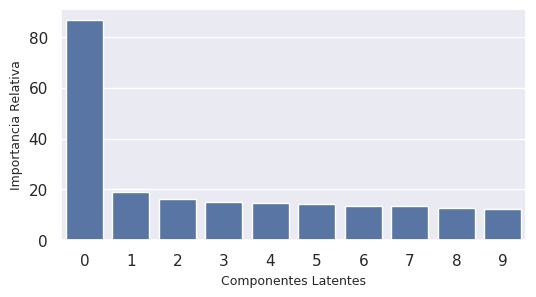

In [27]:
#Creación del gráfico de barras
sns.set(rc={'figure.figsize':(6,3)}) #configura el tamaño de la figura a 6x3
chart = sns.barplot(x=list(range(len(Sigma))), y = Sigma) #se crea el gráfico de barras
chart.set_xlabel('Componentes Latentes', fontdict={'size':9}) #Etiquetas de x y y con fuente de tamaño 9
chart.set_ylabel('Importancia Relativa', fontdict={'size':9});

In [33]:
lsi_team_topic = V_T #Se asignao la matriz transpuesta de los componentes de la descomposición SVD
lsi_team_topic.shape #Imprime la forma de la matriz
term_names = list(tfidf.get_feature_names_out()) #Se obtienen los nombres de las características del objeto y se asignan a una lista

#Se crea un DataFrame a partir de la matriz (term-topic)
term_topic_matrix = pd.DataFrame(data=lsi_team_topic,
                                 index=term_names,
                                 columns=[f'Concepto_Latente_{r}' for r in range(0, V_T.shape[1])])

term_topic_matrix.shape #Forma del dataframe creado

term_topic_matrix.head(10) #se imprimen sus primeros 10 valores

,Concepto_Latente_0,Concepto_Latente_1,Concepto_Latente_2,Concepto_Latente_3,Concepto_Latente_4,Concepto_Latente_5,Concepto_Latente_6,Concepto_Latente_7,Concepto_Latente_8,Concepto_Latente_9
ability,0.000619,-0.001830,0.000519,0.002534,0.000878,-0.000063,0.000319,0.000247,0.000439,-0.001388
abnormality,0.000155,-0.000195,0.000377,-0.000139,-0.000129,-0.000025,-0.000089,0.000065,-0.000621,-0.000170
absence,0.002114,-0.002881,0.002911,0.003087,-0.000997,-0.002094,-0.004854,-0.002225,-0.005067,-0.003907
absent,0.000027,-0.000138,0.000166,0.000357,0.000256,0.000439,-0.000257,-0.000243,-0.000071,0.000677
access,0.001783,-0.001023,-0.000324,-0.000388,-0.001564,-0.000310,-0.001508,-0.005099,0.001955,-0.002415
accessory,0.000219,-0.000657,-0.000111,-0.000759,0.001181,0.000410,0.000217,-0.000468,-0.000316,-0.000712
accident,0.000638,-0.000401,0.000632,0.001939,-0.002358,0.000865,-0.001265,-0.000675,-0.002304,0.002362
accordance,0.000582,0.000306,0.000418,0.001075,-0.000391,0.000140,0.000488,-0.001571,-0.000653,-0.000887
account,0.007343,-0.010145,-0.013348,0.011017,-0.011304,-0.010491,0.003088,-0.000243,-0.012333,-0.009212
acknowledgement,0.000178,0.000234,-0.000295,0.000699,-0.000074,0.000074,-0.000725,0.000473,0.000289,-0.000570


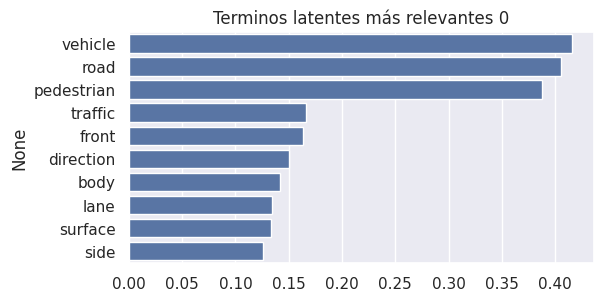

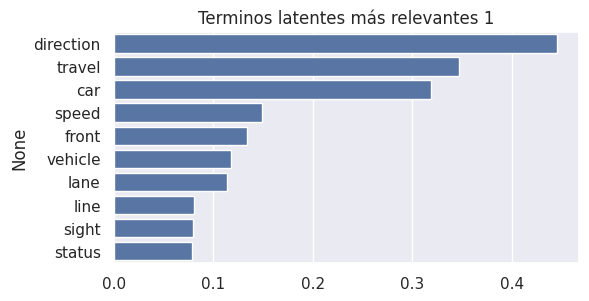

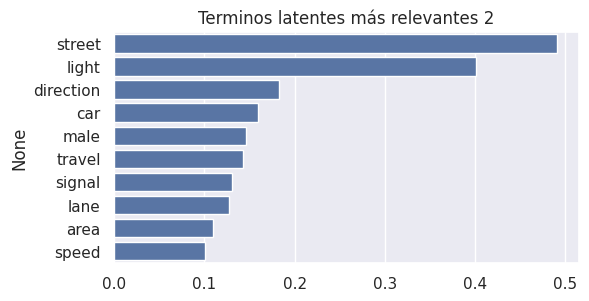

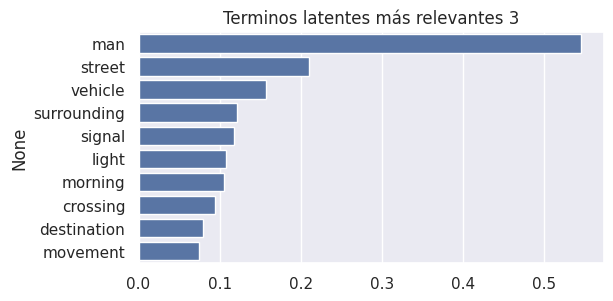

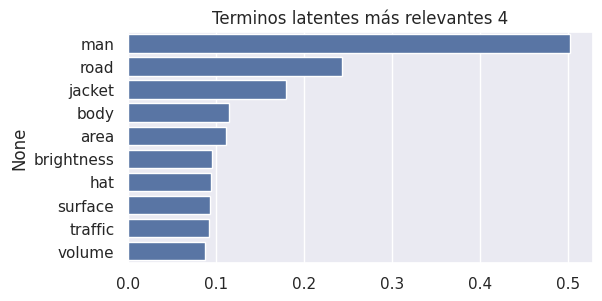

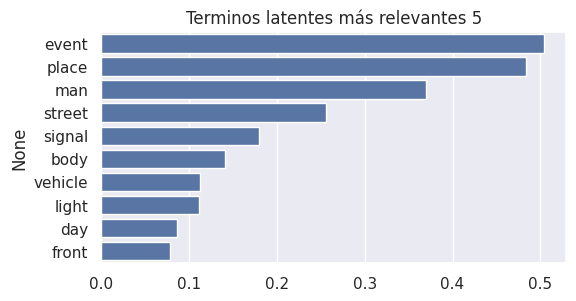

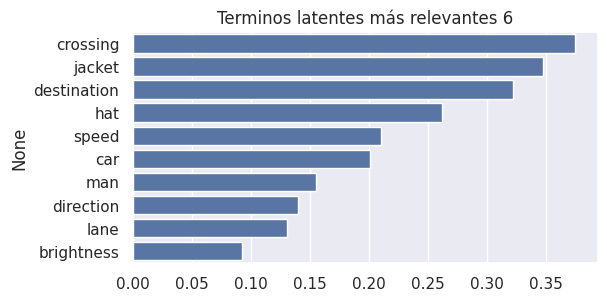

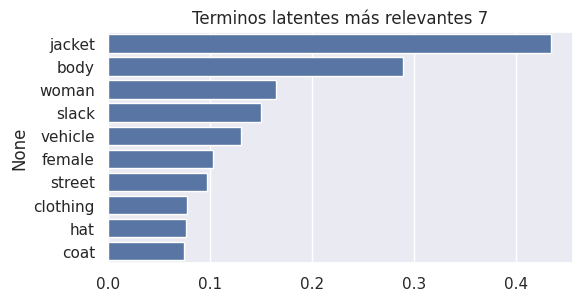

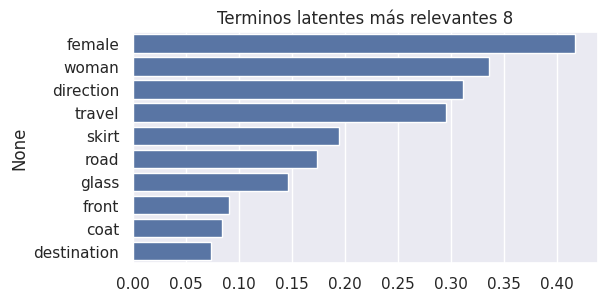

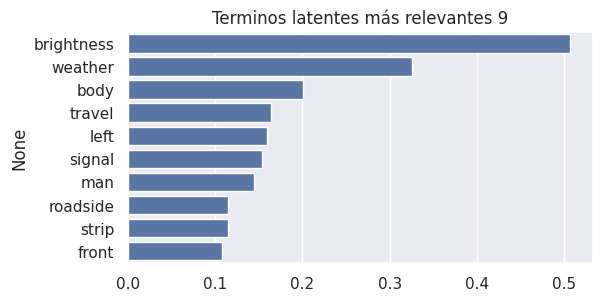

In [31]:
#Creación del gráfico de barras

topics=10
sns.set(rc={ 'figure.figsize':(6,3)}) #tamaño de la figura

for i,cl in enumerate(term_topic_matrix): #se recooren los conceptos latentes
  top_w_matrix = term_topic_matrix[cl].sort_values(ascending=False)[:topics] #para cada concepto se seleccionan los 10 más importantes
  plt.figure(i) #nueva figura para cada grupo de barras
  plt.title(f'Terminos latentes más relevantes {i}')
  sns.barplot(x=top_w_matrix.values, y=top_w_matrix.index)

## Proceso de limpieza - caption_vehicle